<a href="https://colab.research.google.com/github/siruku6/thesis-trial/blob/master/220722_vgg_manual_copy_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG 論文の再現実験

- [Very Deep Convolutional Networks for Large-Scale Image Recognition
](https://arxiv.org/abs/1409.1556)


# 1. Module

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

!pip install -q pytorch_lightning
!pip install -q torchmetrics
!pip install -q torchinfo


env: CUBLAS_WORKSPACE_CONFIG=:4096:8
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 746.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import torchmetrics
from torchmetrics.functional import accuracy
# from torchsummary import summary
from torchinfo import summary

import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18

In [3]:
tens = torch.tensor([[1,2], [3,4], [5,6]])
tens.size(1)

2

In [4]:
from typing import List
import datetime
from glob import glob
import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
from PIL import Image, ImageDraw, ImageFont


In [ ]:
!pip list

# 2. Data

## 2-1 check data in advance

In [8]:
pl.seed_everything(0)
transform = transforms.Compose([
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # PyTorch公式でもこのmean, stdが推奨されている
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aircraft_dataset = torchvision.datasets.FGVCAircraft(
    root='./', split='trainval', annotation_level='variant',
    transform=transform, download=True
)

len(aircraft_dataset)

INFO:lightning_fabric.utilities.seed:Seed set to 0


100%|██████████| 2753340328/2753340328 [01:35<00:00, 28854082.25it/s]


Extracting ./fgvc-aircraft-2013b.tar.gz to ./


6667

In [ ]:
dir(aircraft_dataset)

In [10]:
aircraft_dataset[0][0].shape, aircraft_dataset[0][1], len(aircraft_dataset.classes)

(torch.Size([3, 224, 224]), 0, 100)

## 2-2 create dataloader

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, subset: torch.utils.data.Subset, transform: transforms.Compose = None) -> None:
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes: List[str] = subset.categories

        dropped_len: int = 0
        for image, label in tqdm(subset, desc="Filtering out invalid data"):
            if image.shape[0] != 3:
                del image
                dropped_len += 1
                continue
            # NOTE: There is shortage for RAM
            if label == 20:
                break
            else:
                self.images.append(image)
                self.labels.append(label)

        self.dropped_len = dropped_len

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.labels)


class AircraftDataset(torch.utils.data.Dataset):
    def __init__(self, transform: transforms.Compose = None) -> None:
        self.subset: torch.utils.data.Subset = torchvision.datasets.FGVCAircraft(
            root='./', split='trainval', annotation_level='variant', download=True
        )
        self.transform = transform
        self.classes: List[str] = self.subset.classes

    def __getitem__(self, index):
        image, label = self.subset[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)


In [12]:
pl.seed_everything(0)

transform = transforms.Compose([
    # ImageNetで学習したモデルを使うときは、256->224の変換が一般的
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # PyTorch公式でもこのmean, stdが推奨されている
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# aircraft_dataset = AircraftDataset(transform=transform)

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./', train=False,download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

data_size: int = len(trainset)

n_train: int = int(data_size * 0.8)
n_val: int = data_size - n_train
# n_test: int = data_size - n_train - n_val
train, val = torch.utils.data.random_split(trainset, [n_train, n_val])

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

INFO:lightning_fabric.utilities.seed:Seed set to 0


100%|██████████| 170498071/170498071 [00:02<00:00, 64291276.54it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [13]:
trainset.classes


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## 2-3 check dataloader

In [15]:
# caltech_image_dataset.dropped_len

In [16]:
# len(pd.Series(caltech_image_dataset.labels).drop_duplicates())

In [17]:
img, label = next(iter(train_loader))
print(label[0])
img[0].shape, img[0]

tensor(1)


(torch.Size([3, 224, 224]),
 tensor([[[ 0.8447,  0.7762,  0.6906,  ...,  2.0092,  1.9920,  1.9749],
          [ 0.8618,  0.7933,  0.7077,  ...,  2.0092,  1.9749,  1.9578],
          [ 0.8961,  0.8104,  0.7248,  ...,  1.9920,  1.9578,  1.9407],
          ...,
          [-0.1828, -0.2513, -0.3027,  ...,  0.8104,  0.8447,  0.8789],
          [-0.3027, -0.3712, -0.4397,  ...,  0.6906,  0.7419,  0.7933],
          [-0.4226, -0.5082, -0.5767,  ...,  0.5536,  0.6392,  0.6906]],
 
         [[ 0.8354,  0.7829,  0.7129,  ...,  2.1134,  2.0784,  2.0609],
          [ 0.8529,  0.8004,  0.7304,  ...,  2.1134,  2.0784,  2.0434],
          [ 0.8880,  0.8179,  0.7479,  ...,  2.0959,  2.0609,  2.0259],
          ...,
          [-0.0224, -0.0749, -0.1625,  ...,  1.0805,  1.1155,  1.1331],
          [-0.1450, -0.2150, -0.2850,  ...,  0.9580,  1.0105,  1.0455],
          [-0.2675, -0.3550, -0.4251,  ...,  0.8354,  0.9055,  0.9580]],
 
         [[ 0.4788,  0.3916,  0.2871,  ...,  2.3611,  2.3263,  2.3088],


# 3. Check the goal (Original VGG)

## 3-1 The network of (Original VGG)

In [18]:
use_pretrained: bool = True
net: torchvision.models.vgg.VGG = torchvision.models.vgg16(pretrained=use_pretrained)

net.eval()

print(net)
type(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 147MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

torchvision.models.vgg.VGG

## 3-2 check behaviour

In [19]:
class VGGPresetNet(pl.LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()

        pretrained = True
        self.num_classes = num_classes
        # UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15.
        # The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`.
        # You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
        # self.vgg = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        self.vgg = torchvision.models.vgg16(weights=None)

        # HACK: vgg is too heavy? now checking
        # self.vgg = resnet18(weights='ResNet18_Weights.DEFAULT')
        self.dout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        h = self.vgg(x)
        h = self.dout(h)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log(
            'train_acc',
            accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes),
            on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        # https://github.com/mrdbourke/pytorch-deep-learning/discussions/591
        self.log('test_acc', accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer':optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

sample_vgg = VGGPresetNet(len(trainset.classes))
sample_vgg.eval()

img, label = next(iter(train_loader))
print(label[0])

result = sample_vgg(img[[0]])
result.shape

tensor(8)


torch.Size([1, 10])

# 4. Network

## 4-1 Network architecture

Refer to "2.1 ARCHITECTURE"

- input  
224 * 224 RGB image
- preprocessing  
Subtracting the mean RGB value, computed on the training set, from each pixel
- convolution
    - receptive field: 3 * 3
    - stride: 1 pixel
    - padding  
    such that the spatial resolution is preserved after convolution, i.e. the padding is 1 pixel for 3 * 3 conv.layers.
    - pooling  
    max-pooling (performed over a 2 * 2 window, with stride 2)  
    This follow some of the conv.layers.
- fully conneccted  
A stack of convolution layers is followed by three fully connected layers: the first two have 4096 channels each, the third contains 1000 channels
- softmax layer  
The final layer is the soft-max layer
- activation  
All hidden layes are equipped with the rectification (ReLU) non-linearity.

## 4-2 Hyper parameters

Refer to "3.1 CLASSIFICATION FRAMEWORK"

- optimization  
using mini-batch gradient descent with momentum
- batch size  
256
- momentum  
    0.9
- weight decay  
    - $L_{2}$ penalty multiplier  
$5 * 10^{-4}$
- dropout  
dropout regularisation for the first two fully connected layers
    - dropout ratio  
        0.5
- learning rate
    - initialy set to $10^{-2}$
    - decreased by a factor of 10 when validation set accuracy stopped improving

In [20]:
class VGGNet(pl.LightningModule):
    def __init__(self, num_classes: int, init_weights: bool = True):
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avg_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            # nn.Linear(128 * 7 * 7, 4096)
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1000),
        )

        self.dout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1000, num_classes)

        if init_weights:
            for module in self.modules():
                if isinstance(module, nn.Conv2d):
                    nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")
                    if module.bias is not None:
                        nn.init.constant_(module.bias, 0)
                elif isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)
                elif isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, 0, 0.01)
                    nn.init.constant_(module.bias, 0)

    def forward(self, x):
        h = self.features(x)
        h = self.avg_pool(h)

        h = h.view(-1, 512 * 7 * 7)  # ベクトル化

        h = self.fcs(h)
        h = self.dout(h)
        h = self.fc(h)
        return h

    def training_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes), on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, t = batch
        y = self(x)
        loss = F.cross_entropy(y, t)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', accuracy(y.softmax(dim=-1), t, task="multiclass", num_classes=self.num_classes), on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1)
        return {
            'optimizer':optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }


## continue


In [21]:
# tens = torch.Tensor([[1, 2], [3, 4]])
# tens.view(-1, 4)

In [22]:
vgg_net = VGGPresetNet(len(trainset.classes))
vgg_net.eval()

print(vgg_net)

img, label = next(iter(train_loader))
print(label[0])

result = vgg_net(img[[0]])
result.shape

VGGSampleNet(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

torch.Size([1, 10])

In [23]:
vgg_net = VGGNet(len(trainset.classes))
vgg_net.eval()

print(vgg_net)

img, label = next(iter(train_loader))
print(label[0])

result = vgg_net(img[[0]])
result.shape

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

torch.Size([1, 10])

# 5. training

## 5-1. pre-set VGG


In [24]:
pl.seed_everything(0)

# gpus = 1
logger = CSVLogger(save_dir='logs', name='c_net')
trainer = pl.Trainer(max_epochs=10, devices="auto", deterministic=False, logger=logger)
sample_vgg = VGGPresetNet(len(trainset.classes))
trainer.fit(sample_vgg, train_loader, val_loader)

results = trainer.test(dataloaders=test_loader)
print(results)


INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | vgg  | VGG     | 138 M 
1 | dout | Dropout | 0     
2 | fc   | Linear  | 10.0 K
---------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
553.470   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/c_net/version_0/checkpoints/epoch=9-step=6250.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at logs/c_net/version_0/checkpoints/epoch=9-step=6250.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7752000093460083     │
│         test_loss         │     0.787650465965271     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.787650465965271, 'test_acc': 0.7752000093460083}]


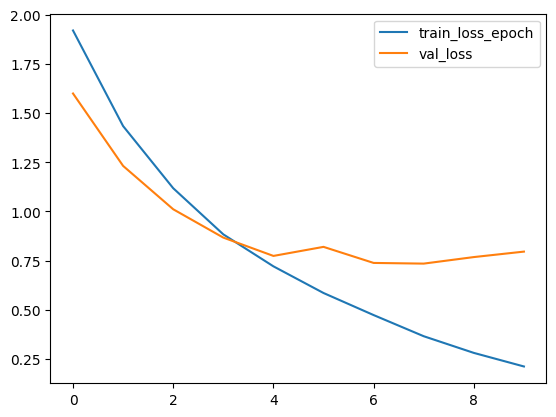

In [25]:
# 結果確認
log = pd.read_csv('logs/c_net/version_0/metrics.csv')

log[['train_loss_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss_epoch'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

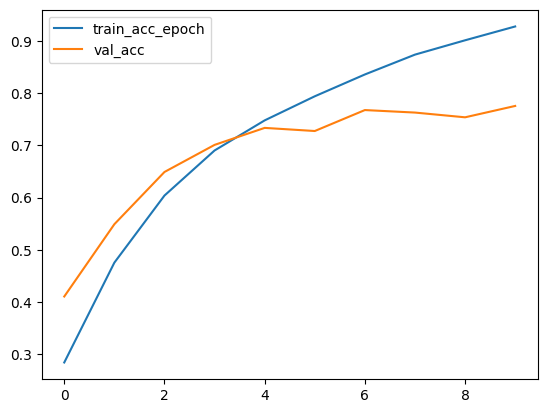

In [26]:
log[['train_acc_epoch', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc_epoch'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()

## 5-2. hand-made VGG


In [ ]:
pl.seed_everything(0)

# gpus = 1
logger = CSVLogger(save_dir='logs', name='c_net')
trainer = pl.Trainer(max_epochs=10, devices="auto", deterministic=False, logger=logger)
vgg = VGGNet(len(trainset.classes))
trainer.fit(vgg, train_loader, val_loader)

results = trainer.test(dataloaders=test_loader)
print(results)


INFO:lightning_fabric.utilities.seed:Seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type              | Params
-----------------------------------------------
0 | features | Sequential        | 14.7 M
1 | avg_pool | AdaptiveAvgPool2d | 0     
2 | fcs      | Sequential        | 123 M 
3 | dout     | Dropout           | 0     
4 | fc       | Linear            | 10.0 K
-----------------------------------------------
138 M     Trainable params
0         Non-trainable params
138 M     Total params
553.470   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# 結果確認
log = pd.read_csv('logs/c_net/version_1/metrics.csv')

log[['train_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['train_loss'].plot()
log[['val_loss', 'epoch']].dropna(how='any', axis=0).reset_index()['val_loss'].plot()
plt.legend()

In [ ]:
log[['train_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['train_acc'].plot()
log[['val_acc', 'epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot()
plt.legend()